Final results of `Predicted Clusters`. Such clusters have been created by `clustering.py` of the Beard application that groups together signatures belonging to the same author, where each author is represented by a `Predicted Cluster` (key-value pair in a JSON array).

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import chain
from json import load
from math import ceil
from matplotlib import rc

In [8]:
predicted_clusters = load(open("/data01/beard/clustering/predicted_clusters.json"))

In [4]:
signatures = load(open("/data01/beard/clustering/signatures.json"))
signatures = {s["signature_id"]: s for s in signatures}

In [70]:
data = [len(signatures), len(predicted_clusters)]
index = ['Signatures',  # Total number of signatures
         'Predicted Clusters',  # Total number of predicted clusters
        ]
d = {'Count': data}
df = pd.DataFrame(data=d, index=index)
df

,Count
Signatures,8958311
Predicted Clusters,395720


Since signature ids are in the format `<publication id>_<author fullname>_<continous number>`, it easily allows you to find the cluster a signature belongs to:

In [56]:
for cluster in predicted_clusters:
    if any("_Ellis, John" in signature_id for signature_id in predicted_clusters[cluster]):
        print cluster

366147


A predicted cluster is represented as a key-value pair:

In [58]:
cluster = "50000"
{cluster: predicted_clusters[cluster]}

{'50000': [u'1188053_Plisson, T_3903969',
  u'1206153_Plisson, Thomas_3939787',
  u'1278942_Plisson, Thomas_4236535',
  u'1390661_Plisson, T_4999845',
  u'1463222_Plisson, Thomas_5704725']}

Lets do some statistics for the predicted clusters:

In [9]:
# List of predicted_cluster `keys`, sorted by the number of signatures each cluster
predicted_clusters_sorted = sorted(predicted_clusters,
                                   key=lambda k: len(predicted_clusters[k]))

# List of the number of signatures each cluster, in ascending order
predicted_clusters_size_sorted = [
    len(predicted_clusters[c]) for c in predicted_clusters_sorted]

s_mean = np.mean(np.array(predicted_clusters_size_sorted))
c_median = np.median(np.array(predicted_clusters_size_sorted))
c_min = predicted_clusters_size_sorted[0]
c_max = predicted_clusters_size_sorted[len(predicted_clusters_size_sorted) - 1]

# Number of clusters below and above the mean cluster size of 23:
# If `ValueError: mean is not in list`, try +/- 1 until index found
mean = ceil(s_mean)
c_equal_mean = predicted_clusters_size_sorted.count(mean)
c_below_mean = predicted_clusters_size_sorted.index(mean) - 1
c_above_mean = len(predicted_clusters) - c_below_mean
assert(c_below_mean + c_above_mean == len(predicted_clusters))

In [5]:
# Print results
data = [len(predicted_clusters_size_sorted),
        s_mean,
        c_median,
        c_below_mean,
        c_above_mean,
        c_min,
        c_max,
       ]
index = ['Total',  # Total number of predicted clusters
         'Arithmetic mean m',  # Average cluster size (number of signatures for each cluster)
         'Median',  # Median of the cluster size
         'Below (<) m',  # Number of clusters below having less signatures than the average size
         'Above (>=) m',  # Number of clusters below having more or equal signatures than the average size
         'Min',  # Lowest cluster size
         'Max'  # Biggest cluster size
        ]
d = {'Count': data}
df = pd.DataFrame(data=d, index=index)
# s = pd.Series(data, index=index)
df

,Count
Total,395720.000000
Arithmetic mean m,22.638002
Median,2.000000
Below (<) m,342983.000000
Above (>=) m,52737.000000
Min,1.000000
Max,2807.000000


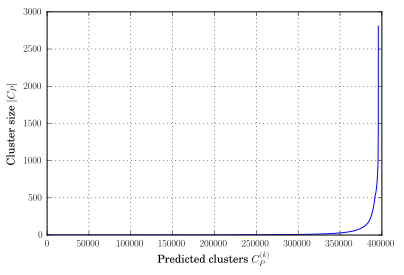

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.xlabel('Predicted clusters $C_{P}^{(k)}$', fontsize=11)
plt.ylabel(r'Cluster size $\vert C_{P} \vert$', fontsize=11)
plt.grid(True)
plt.plot(predicted_clusters_size_sorted)
# plt.savefig('predicted-clusters.pdf', format='pdf')
plt.show()

In [65]:
# Format: {cluster: list of signature ids having a authority id}
clusters_having_cds_id = {}
clusters_having_cern_id = {}
clusters_having_inspire_id = {}

for cluster in predicted_clusters:
    for signature_id in predicted_clusters[cluster]:
        signature = signatures[signature_id]

        if signature.get("author_cds_id"):
            try:
                clusters_having_cds_id[cluster].append(signature_id)
            except KeyError:
                clusters_having_cds_id[cluster] = [signature_id]

        if signature.get("author_cern_id"):
            try:
                clusters_having_cern_id[cluster].append(signature_id)
            except KeyError:
                clusters_having_cern_id[cluster] = [signature_id]

        if signature.get("author_inspire_id"):
            try:
                clusters_having_inspire_id[cluster].append(signature_id)
            except KeyError:
                clusters_having_inspire_id[cluster] = [signature_id]

s_cds = sum(len(cluster) for cluster in clusters_having_cds_id.itervalues())
c_cds = len(clusters_having_cds_id)
s_cern = sum(len(cluster) for cluster in clusters_having_cern_id.itervalues())
c_cern = len(clusters_having_cern_id)
s_inspire = sum(len(cluster) for cluster in clusters_having_inspire_id.itervalues())
c_inspire = len(clusters_having_inspire_id)

# Distinct signatures
s_distinct = len(
    set(list(chain.from_iterable([s for s in clusters_having_cds_id.itervalues()])) +
        list(chain.from_iterable([s for s in clusters_having_cern_id.itervalues()])) +
        list(chain.from_iterable([s for s in clusters_having_inspire_id.itervalues()]))))

# Distinct clusters
c_distinct = len(
    set(clusters_having_cds_id.keys() +
        clusters_having_cern_id.keys() +
        clusters_having_inspire_id.keys()))

In [69]:
# Print results
data = [('CDS authority ids', [s_cds, c_cds]),
        ('CERN authority ids', [s_cern, c_cern]),
        ('INSPIRE authority ids', [s_inspire, c_inspire]),
        ('Total (distinct)', [s_distinct, c_distinct]),
       ]
columns = ['#Signatures',  # Number of signatures having authority ids
           '#Clusters',  # Number of clusters containing signature with authority id
          ]
df = pd.DataFrame.from_items(data, orient='index', columns=columns)
df

,#Signatures,#Clusters
CDS authority ids,1136,580
CERN authority ids,1121167,6830
INSPIRE authority ids,2922943,14665
Total (distinct),2927170,15744
